# Multi-class Classification Using DenseNet

Let's build a dense network for single-label, multi-class classification. The reuters dataset preloaded in keras has 46 labels.Each input sentence will fall under one of these labels.

In [100]:
from keras.datasets import reuters

We'll limit the input sentences to the most frequent 10,000 words to get rid of rare words.

In [45]:
(training_input, training_label), (test_input, test_label) = reuters.load_data(num_words = 10000)

Let's peek at the first 15 indices in the first training sentence.

In [79]:
example1 = training_input[0][:15]
print(example1)

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16]


This sentence falls under label 3.

In [47]:
training_label[0]

3

In [52]:
print("There are {} training inputs and {} corresponding training labels.".format(
len(training_input), len(training_label)))

There are 8982 training inputs and 8982 corresponding training labels.


In [53]:
print("There are {} test inputs and {} corresponding test labels.".format(
len(test_input), len(test_label)))

There are 2246 test inputs and 2246 corresponding test labels.


Let's take a look at the dictionary mapping words to index.

In [55]:
word2index = reuters.get_word_index()
list(word2index.items())[:15]

[('mdbl', 10996),
 ('fawc', 16260),
 ('degussa', 12089),
 ('woods', 8803),
 ('hanging', 13796),
 ('localized', 20672),
 ('sation', 20673),
 ('chanthaburi', 20675),
 ('refunding', 10997),
 ('hermann', 8804),
 ('passsengers', 20676),
 ('stipulate', 20677),
 ('heublein', 8352),
 ('screaming', 20713),
 ('tcby', 16261)]

Create the reverse dictionary mapping from indices to words.

In [56]:
index2word = {j:i for i,j in word2index.items()}

Let's use the reverse dictionary to convert the first input sentence to words.

In [57]:
" ".join([index2word.get(word-3,'?') for word in training_input[0]])

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

Next, we plot the distribution of the labels.

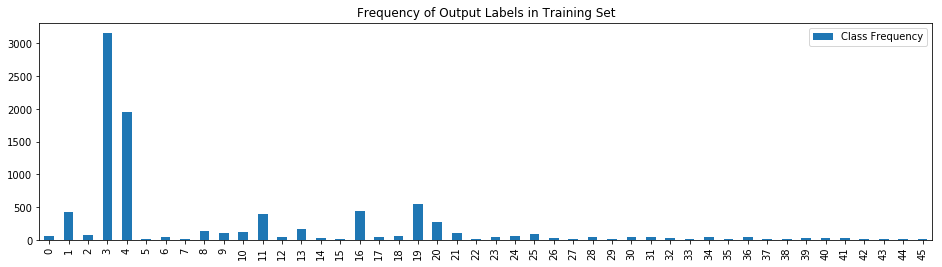

In [58]:
class_freq = {i:sum((training_label == i) == True) for i in set(training_label) }
freq = list(class_freq.values())

import pandas as pd
class_freq = {"Class Frequency":freq}
df = pd.DataFrame(index = range(46), data = class_freq)
df.plot(kind = 'bar', figsize = (16,4), title = 'Frequency of Output Labels in Training Set')

We can see that label 3 and label 3 have very high frequencies, while some others such as label 44 and 45 occur only once or twice. 

We create a function random_pred() that helps us to run 1000 simulations. It will tell us 
how many correct labels one can get by pure luck.

In [64]:
import random, copy
def random_pred(label, times = 1000):
    averages = 0
    for i in range(times):
        label1= copy.copy(label)
        random.shuffle(label1)
        right_guess = np.sum(label1 == label)
        average = right_guess/len(label)
        averages +=average
    
    return averages/times

random_pred(training_label)

0.18390325094633692

On average, one would get 18.3% correct just by random luck.  
  
  
Alternatively, we can also use the formula for the [expected value of a function](https://revisionmaths.com/advanced-level-maths-revision/statistics/expectation-and-variance) to calculate how many times we can expect to get correct labels by pure luck. 

$$
ExpectedValue = \sum_{i=0}^{45}Frequency (label_i)  \times Probability(label_i) 
$$

In [76]:
total = np.sum(class_freq['Class Frequency'])
expected_value = np.sum([i*i/total for i in class_freq['Class Frequency']])

print("We should expect to get {} random guesses correct when we try {} times randomly.".format
      (expected_value,total))

We should expect to get 1650.4825205967493 random guesses correct when we try 8982 times randomly.


In [77]:
expected_value/total

0.18375445564426066

This also gives us around 18.3%, very close to our simulated guess. 
  

Let's convert the input sentences in the test and training sets into binary matrixes.

In [72]:
import numpy as np

def vectorize_sentence(data, dimension = 10000):
    binary_matrix = np.zeros((len(data), dimension))
    for i, word in enumerate(data):
        binary_matrix[i,word]= 1
    return binary_matrix    

In [75]:
training_input_binary = vectorize_sentence(training_input)
test_input_binary = vectorize_sentence(test_input)

In [81]:
print('The shape of training input will become {}. \
As illustration, the first training example will be transformed from {} to \
{}'.format(training_input_binary.shape, example1, training_input_binary[0]))

The shape of training input will become (8982, 10000). As illustration, the first training example will be transformed from [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16] to [0. 1. 1. ... 0. 0. 0.]


Let's build a Dense Neural Network with 2 hidden layers, each with 64 nodes. With 64 nodes, there will be lower chance of any information bottleneck. As the final layer has 46 classes, larger layers are needed so that the representations at the final layers are useful for making 46 probabilistic predictions.

In [82]:
from keras.models import Sequential
from keras.layers import Dense

In [83]:
model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape = (10000,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(46, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


Because we are using 'sparse_categorical_crossentropy' as loss, there is no need to tranform the labels at all.

In [84]:
model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

In [85]:
history = model.fit(training_input_binary, 
                    training_label,
                    epochs = 10, 
                    batch_size = 128,
                    validation_split = 0.2)

Train on 7185 samples, validate on 1797 samples
Epoch 1/10
7185/7185 [==============================] - 1s 124us/step - loss: 1.8833 - acc: 0.6021 - val_loss: 1.3052 - val_acc: 0.7106
Epoch 2/10
7185/7185 [==============================] - 1s 111us/step - loss: 1.0372 - acc: 0.7749 - val_loss: 1.1016 - val_acc: 0.7652
Epoch 3/10
7185/7185 [==============================] - 1s 102us/step - loss: 0.7126 - acc: 0.8438 - val_loss: 1.0133 - val_acc: 0.7769
Epoch 4/10
7185/7185 [==============================] - 1s 100us/step - loss: 0.4990 - acc: 0.8938 - val_loss: 1.0518 - val_acc: 0.7691
Epoch 5/10
7185/7185 [==============================] - 1s 102us/step - loss: 0.3535 - acc: 0.9222 - val_loss: 0.9150 - val_acc: 0.8041
Epoch 6/10
7185/7185 [==============================] - 1s 103us/step - loss: 0.2665 - acc: 0.9420 - val_loss: 0.9744 - val_acc: 0.7941
Epoch 7/10
7185/7185 [==============================] - 1s 103us/step - loss: 0.2101 - acc: 0.9489 - val_loss: 1.0135 - val_acc: 0.7824


In [86]:
import matplotlib.pyplot as plt

In [87]:
val_acc = history.history['val_acc']
acc = history.history['acc']
val_loss = history.history['val_loss']
loss = history.history['loss']
epoch = range(1, len(val_acc)+1)

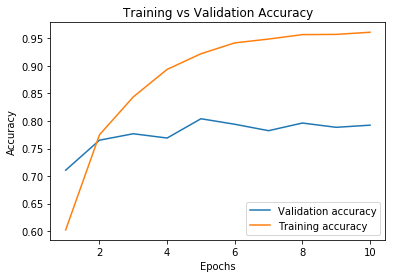

In [88]:
plt.plot(epoch, val_acc, label = 'Validation accuracy')
plt.plot(epoch, acc, label = 'Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training vs Validation Accuracy')
plt.legend()

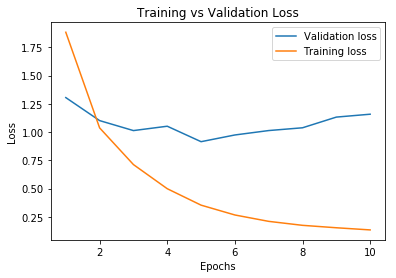

In [89]:
plt.plot(epoch, val_loss, label = 'Validation loss')
plt.plot(epoch, loss, label = 'Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training vs Validation Loss')
plt.legend()

The model started overfitting around the 5th epochs. Let's retrain the model for 5 epochs and evaluate the model on the test set.

In [94]:
model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape = (10000,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(46, activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

history = model.fit(training_input_binary, 
                    training_label,
                    epochs = 5, # change to 6 epochs
                    batch_size = 128,
                    validation_split = 0.2)

Train on 7185 samples, validate on 1797 samples
Epoch 1/5
7185/7185 [==============================] - 1s 128us/step - loss: 1.8691 - acc: 0.6171 - val_loss: 1.3009 - val_acc: 0.6884
Epoch 2/5
7185/7185 [==============================] - 1s 105us/step - loss: 0.9863 - acc: 0.7854 - val_loss: 1.0717 - val_acc: 0.7618
Epoch 3/5
7185/7185 [==============================] - 1s 102us/step - loss: 0.6642 - acc: 0.8554 - val_loss: 0.9787 - val_acc: 0.7813
Epoch 4/5
7185/7185 [==============================] - 1s 103us/step - loss: 0.4596 - acc: 0.9030 - val_loss: 0.9388 - val_acc: 0.7952
Epoch 5/5
7185/7185 [==============================] - 1s 106us/step - loss: 0.3266 - acc: 0.9307 - val_loss: 0.9247 - val_acc: 0.8041


In [97]:
loss_test, accuracy_test = model.evaluate(test_input_binary, test_label)
print("loss: {}, accuracy: {}".format(loss_test, accuracy_test))

2246/2246 [==============================] - 0s 179us/step
loss: 0.9829077737626495, accuracy: 0.7880676758682101


The model has an accuracy of 78%, compared to a baseline of 18%.  



Reference:

1) Deep Learning with Python - Francois Chollet
